# Create Datasets

Use this notebook to create synthetic regression datasets to use with the ML pipeline.

## Imports

In [1]:
import os

import boto3 as aws
import seaborn as sns
from pandas import DataFrame
from numpy.random import choice, randn, seed, standard_normal

## Configuration

In [2]:
sns.set()
seed(42)

AWS_S3_PROJECT_BUCKET = "bodywork-pipeline-with-aporia-monitoring"

## Create Synthetic Data

We will use NumPy to create synthetic regression data via random number generation. There will be one numeric feature, $\tilde{F_1}$, and one categorical feature, $\tilde{F_2}$, where the categorical feature can be one of three classes ('c0', 'c1', or 'c3'). The labels, $\tilde{y}$, will be generated from the features, using the following equation,

$$
\tilde{y} = \beta_{\tilde{F_2}} \times \tilde{F_1} + \sigma \times \tilde{\epsilon}
$$

Where $\beta_{c_0}$, $\beta_{c_1}$ and $\beta_{c_2}$ are constant parameters that control the impact of $\tilde{F_1}$ on $y$, and $\tilde{\epsilon}$ is a random 'noise' term, whose magniture is controlled by $sigma$. Both $\tilde{F_1}$ and $\tilde{\epsilon}$ will be sampled from the standard Normal distribution, whereas the category assigned to $\tilde{F_2}$ will be chosen at random. The algorithm for this data generating process is implemeted in the cell below.

,y,F_1,F_2
0,0.110304,0.048522,c2
1,-0.193846,-0.830950,c0
2,0.369660,0.270457,c2
3,-0.129525,-0.050238,c2
4,-0.226997,-0.238948,c0


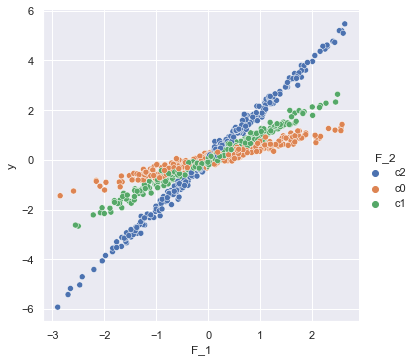

In [3]:
def generate_dataset(
    n_obs: int, beta_c0: float, beta_c1: float, beta_c2: float, sigma: float
) -> DataFrame:
    """Create synthetic dataset given parameters."""
    category_to_beta_map = {"c0": beta_c0, "c1": beta_c1, "c2": beta_c2}
    category = choice(["c0", "c1", "c2"], size=n_obs)
    beta_c = [category_to_beta_map[e] for e in category]
    x = standard_normal(n_obs)
    eta = standard_normal(n_obs)
    y = beta_c * x + sigma * eta
    return DataFrame({"y": y, "F_1": x, "F_2": category})


dataset = generate_dataset(1000, 0.5, 1.0, 2.0, 0.15)
display(dataset.head())
_ = sns.relplot(x="F_1", y="y", hue="F_2", data=dataset)

## Saving the Dataset to Cloud Object Storage

We will use the synthetic data generator to create two datasets - one for training a model that we will deploy as a prediction service (the 't=0' dataset), and another for testing the prediction service, that will be monitored using Aporia (the 't=1' dataset). The parameters used to create each dataset will be different - i.e. so that there is a deliberate concept drift beween `t=0` and `t=1` datasets.

In [4]:
# generate datasets
dataset_t0 = generate_dataset(1000, 0.5, 1.0, 2.0, 0.15)
dataset_t1 = generate_dataset(1000, 0.5, 2.0, 4.0, 0.25)

# persist datasets locally 
dataset_t0.to_csv("dataset_t0.csv", header=True, index=False)
dataset_t1.to_csv("dataset_t1.csv", header=True, index=False)

# upload datasets to AWS S3
s3_client = aws.client('s3')
s3_client.upload_file(
    "dataset_t0.csv",
    AWS_S3_PROJECT_BUCKET,
    "datasets/dataset_t0.csv"
)
s3_client = aws.client('s3')
s3_client.upload_file(
    "dataset_t1.csv",
    AWS_S3_PROJECT_BUCKET,
    "datasets/dataset_t1.csv"
)

# remove local files
os.remove("dataset_t0.csv")
os.remove("dataset_t1.csv")